# Proyek Akhir : Image Classification Model Deployment

Tujuan proyek ini adalah mengembangkan model ML untuk klasifikasi gambar kemudian mengkonversi model tersebut ke dalam format berkas TF-Lite yang dapat di embed di Android dan iOS.

1. Dataset minimal 1000 gambar, sebaiknya 2000 - 10000 gambar.

2. Dataset dibagi menjadi train set (80%) dan test set (20%).

3. Menggunaan model sequental.

4. Menggunakan Conv2D Maxpooling Layer.
5. Akurasi pada training dan validation set minimal sebesar 80%.
6. Menggunakan Callback.

7. Plot terhadap akurasi dan loss model.

8. Deployment dalam format TF-Lite.

+ Resolusi gambar sebaiknya tidak seragam.
+ Minimal 3 kelas.
+ Akurasi 85% atau 92%

Dataset : Skin Cancer MNIST: HAM10000 ("Human Against Machine with 10000 training images")

Source : https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000?select=hmnist_28_28_RGB.csv

Sampel dataset 10K

Image classification model dataset ini bertujuan agar baik orang awam dapat mengenal pigmentasi pada kulit, apakah termasuk kanker kulit atau bukan

##import library

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Mount Gdrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
# Download dataset
!wget --no-check-certificate \
    hmnist_28_28_RGB.csv.zip

--2021-07-15 02:52:18--  http://hmnist_28_28_rgb.csv.zip/
Resolving hmnist_28_28_rgb.csv.zip (hmnist_28_28_rgb.csv.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘hmnist_28_28_rgb.csv.zip’


In [ ]:
!ls

In [ ]:
!unzip \hmnist_28_28_RGB.csv.zip &> /dev/null 
print("Berhasil Ekstrak")

Berhasil Ekstrak


In [ ]:
!ls

## metadata

In [ ]:
# upload metadata
metadata = pd.read_csv("/content/HAM10000_metadata.csv")
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
disease_class = metadata['dx'].value_counts()
disease_class.unique()

array([6705, 1113, 1099,  514,  327,  142,  115])

In [ ]:
disease_class.sum()

10015

Text(0.5, 1.0, 'Disease class distribution')

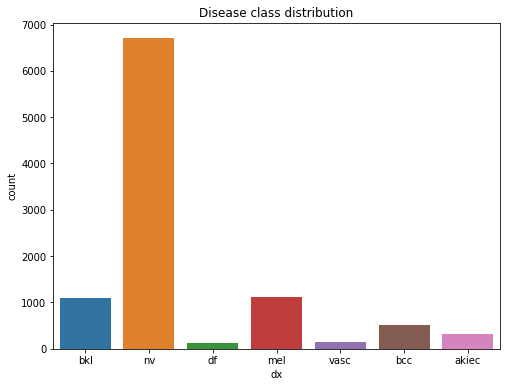

In [ ]:
plt.figure(figsize = (8,6))
sns.countplot(x = 'dx', data = metadata)
plt.title('Disease class distribution')

## Input Dataset

Membuka dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/hmnist_28_28_RGB.csv')
df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,pixel0039,...,pixel2313,pixel2314,pixel2315,pixel2316,pixel2317,pixel2318,pixel2319,pixel2320,pixel2321,pixel2322,pixel2323,pixel2324,pixel2325,pixel2326,pixel2327,pixel2328,pixel2329,pixel2330,pixel2331,pixel2332,pixel2333,pixel2334,pixel2335,pixel2336,pixel2337,pixel2338,pixel2339,pixel2340,pixel2341,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,162,192,208,165,201,209,165,205,208,165,194,212,169,198,216,181,204,216,178,204,215,172,205,217,173,209,217,166,202,214,...,216,181,212,215,176,208,213,168,191,209,159,184,212,168,194,212,172,198,208,173,193,203,168,183,190,142,152,177,123,134,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,128,158,172,136,162,175,134,157,177,126,158,186,138,163,197,153,187,198,153,186,203,168,206,205,169,204,207,164,199,205,...,209,176,203,207,171,191,208,172,197,205,169,188,198,159,172,200,159,192,191,140,182,177,128,141,147,101,97,113,79,82,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,149,165,207,149,159,209,156,164,202,136,130,200,133,129,208,146,157,212,159,167,214,157,168,211,143,150,215,148,169,213,...,221,168,175,222,170,188,221,167,184,203,144,155,201,146,155,210,163,177,190,142,152,192,152,172,194,153,176,178,134,149,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,125,134,177,118,123,190,137,146,192,127,143,200,141,162,207,156,170,202,144,151,202,138,155,212,159,177,211,155,172,211,...,181,137,145,189,147,166,192,157,185,169,129,144,148,114,122,157,125,137,157,127,147,154,128,147,130,102,114,87,63,73,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,179,214,232,189,222,235,193,219,234,191,206,238,200,219,244,213,240,243,213,239,242,210,238,244,216,241,247,224,244,246,...,238,195,209,237,191,200,238,194,201,239,197,216,238,195,219,232,179,201,217,150,173,224,171,207,227,177,206,222,178,201,209,166,185,172,135,149,109,78,92,2


Dataframe menunjukkan resolusi gambar dalam pixel yang berbeda-beda.

In [5]:
df.shape

(10015, 2353)

Terdapat 10015 gambar.

## Data pre-processing

In [6]:
label = df["label"]
df1 = df.drop(columns=["label"]) 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


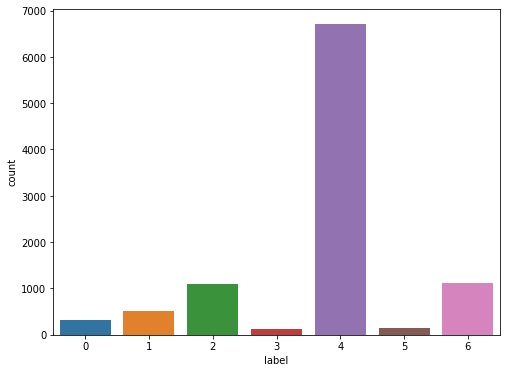

In [7]:
plt.figure(figsize = (8,6))
sns.countplot(label)

Data imbalance, maka akan menggunakan Random Over Sampler

In [8]:
sampler = RandomOverSampler()
df1, label = sampler.fit_resample(df1, label)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


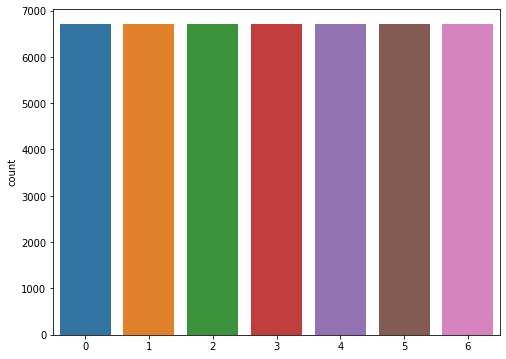

In [9]:
plt.figure(figsize = (8,6))
sns.countplot(label)

In [52]:
df1.shape

(46935, 2352)

## Split dataset

In [10]:
# Split dataset train set (80%) dan test set (20%)
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(df1, label, test_size = 0.2)

In [11]:
# Mengubah data menjadi ukuran metrik yang sama 28x28x3
X_train = np.array(X_train).reshape(-1,28,28,3)
X_test = np.array(X_test).reshape(-1,28,28,3)

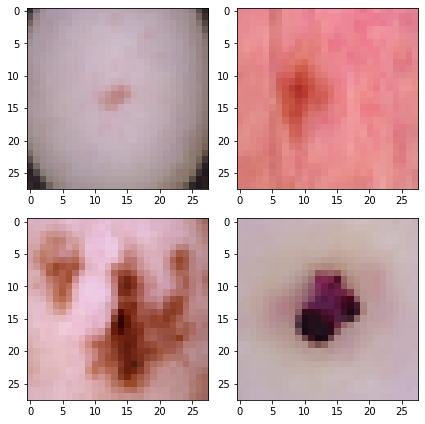

In [12]:
# Visualisasi random image
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(6, 6)
k = 0 
for i in range(2):
    for j in range(2):
        axes[i, j].imshow(X_train[k])
        k += 1
plt.tight_layout()

In [13]:
# encoding label menjadi seperti [0, 1, 0, 0, 0, 0, 0], agar dapat dapat digunakan dalam training
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

## Build Model Machine Learning

Membuat CNN dengan 2 lapis layer konvolusi dan maxpooling



In [34]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

In [35]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation='softmax') 
])

In [36]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [37]:
# Menyimpan dan membuat folder model
model._name = 'skincancer_CNN'
model_save_path = "."
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

In [38]:
model.summary()

Model: "skincancer_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 7, 7, 64)       

## Model Training

In [39]:
#Callback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stop = EarlyStopping(patience=10, verbose=1, monitor='val_accuracy', mode='max')
reduce_lr =  ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=7, min_delta=1e-4, mode='max')
checkpoint = ModelCheckpoint(os.path.join(model_save_path, model.name+".h5"), save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')

In [40]:
history = model.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=128,
                    steps_per_epoch=len(X_train)//128,
                    validation_data= (X_test, y_test),
                    callbacks=[early_stop, checkpoint, 
                               reduce_lr])

Epoch 1/30
293/293 [==============================] - 7s 17ms/step - loss: 1.0793 - accuracy: 0.6031 - val_loss: 1.4821 - val_accuracy: 0.4451

Epoch 00001: val_accuracy improved from -inf to 0.44508, saving model to ./skincancer_CNN.h5
Epoch 2/30
293/293 [==============================] - 4s 15ms/step - loss: 0.4718 - accuracy: 0.8284 - val_loss: 0.8246 - val_accuracy: 0.7318

Epoch 00002: val_accuracy improved from 0.44508 to 0.73176, saving model to ./skincancer_CNN.h5
Epoch 3/30
293/293 [==============================] - 4s 15ms/step - loss: 0.3018 - accuracy: 0.8921 - val_loss: 0.7051 - val_accuracy: 0.7728

Epoch 00003: val_accuracy improved from 0.73176 to 0.77277, saving model to ./skincancer_CNN.h5
Epoch 4/30
293/293 [==============================] - 4s 15ms/step - loss: 0.2162 - accuracy: 0.9216 - val_loss: 1.0488 - val_accuracy: 0.7233

Epoch 00004: val_accuracy did not improve from 0.77277
Epoch 5/30
293/293 [==============================] - 5s 16ms/step - loss: 0.1674 - 

In [41]:
# Akurasi Model
accuracy = history.history["accuracy"]
loss = history.history["loss"]

val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

print("Akurasi training {0}% dan training loss {1}%".format(accuracy[-1]*100, loss[-1]*100))
print("Akurasi validation {0}% dan validation loss {1}%".format(val_accuracy[-1]*100, val_loss[-1]*100))

Akurasi training 99.99198317527771% dan training loss 0.05636691930703819%
Akurasi validation 98.86012673377991% dan validation loss 5.836629495024681%


## Plot Akurasi dan Loss

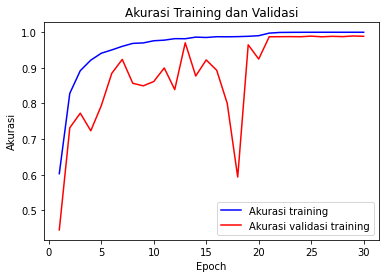

In [49]:
#Plot Akurasi
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, acc, color="blue", label="Akurasi training")
plt.plot(epochs, val_acc, color="red", label="Akurasi validasi training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.title("Akurasi Training dan Validasi")
plt.show()

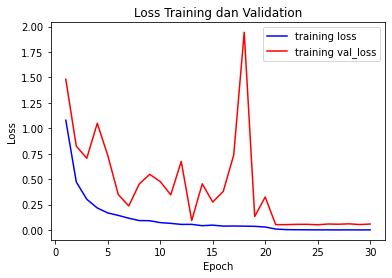

In [50]:
# Plot Loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, loss, color="blue", label="training loss")
plt.plot(epochs, val_loss, color="red", label="training val_loss")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Training dan Validation")

plt.show()

## Deployment untuk Android

In [44]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpck4usvdx/assets


INFO:tensorflow:Assets written to: /tmp/tmpck4usvdx/assets


In [45]:
# Menyimpan model
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [46]:
!ls -la | grep 'model'

-rw-r--r-- 1 root root 5106644 Jul 15 06:57 model.tflite


# Kesimpulan


Model Machine Learning Dataset Skin Cancer Image Classification ini telah mencapai akurasi yang baik yaitu akurasi training 99.9% dan akurasi validasi 98.8%. Dataset ini menggunakan 10015 sampel dan terdiri dari 7 kelas dengan resolusi gambar yang tidak seragam, serta telah di RandomOver. Model telah menerapkan :
1. Penggunaan sequental.
2. Penggunakan Conv2D Maxpooling Layer.
3. Penggunakan Callback.
4. Plot terhadap akurasi dan loss model.
9. Deployment dalam format TF-Lite.

# Thank you for reviewing this notebook!

### This Notebook written by Tsaniyah Nur Kholilah. 2021. As part of Digitalent Kominfo Scholarship Project Completion

---



---



https://www.dicoding.com/users/tsancode
